# Image Search Engine

## 1- Import tf 2 and check GPU support

In [1]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10789649247113124794,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1436473753
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14016015609818023088
 physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"]

## 2 Import required libs

In [269]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import pickle

from tqdm.notebook import tqdm
from scipy.spatial import distance

%matplotlib inline

## 3 Load dataset

In [4]:
def image_loader(image_path, image_size):
    """ Load an image from the disk """
    
    image = cv2.imread(image_path) #BGR
    # convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # resize using cubic interpolation, a way to deal with missing data (upsize or downsize)
    image = cv2.resize(image, image_size, cv2.INTER_CUBIC) 
    
    return image

In [5]:
def dataset_preprocessing(dataset_path, labels_file_path, image_size, image_paths_pickle):
    """ load images and labels from the dataset folder """
    
    with open(labels_file_path,  "r") as f:
        classes = f.read().split("\n")[:-1]
    images = []
    labels = []
    image_paths = []
    
    for image_name in tqdm(os.listdir(dataset_path), desc="loading images", unit="image loading"):
        
        try:
            image_path = os.path.join(dataset_path, image_name)
            images.append(image_loader(image_path, image_size))
            image_paths.append(image_path)
            
            for idx in range(len(classes)):
                if classes[idx] in image_name: # exemple 0_frog.png
                    labels.append(idx)
        except Exception as e:
            print(e)
    
    with open('../data/preprocessed/' + image_paths_pickle + '.pkl', 'wb') as f:
        pickle.dump(image_paths, f)
        
    assert len(images) == len(labels)
    
    return np.array(images), np.array(labels)

In [6]:
images, labels = dataset_preprocessing("../data/raw/train", "../data/raw/labels.txt", (32, 32), "training_images_pickle")

In [7]:
images.shape # 50000 images, 32x32 size with 3 channels 

(50000, 32, 32, 3)

## 4 Utils methods

### 4.1 cosine distance
<img src="../reports/consine_Dot_Product.png">
<img src="../reports/cosine.png">

In [250]:
def cosine_distance(training_set_vectors, query_vector, top_n=50):
    """ calculate cosine distance """
    
    distances = []
    
    for i in tqdm(range(len(training_set_vectors))): # CIFAR-10 has 50k images
        distances.append(distance.cosine(training_set_vectors[i], query_vector[0]))
    
    return np.argsort(distances)[:top_n]

### 4.2 hamming distance

Used only on binary values. Hamming distance = number of items different between A and B

<img src="../reports/hamming.png">

In [253]:
def hamming_distance(training_set_vectors, query_vector, top_n=50):
    """ calculate hamming distance """
    
    distances = []
    
    for i in tqdm(range(len(training_set_vectors))): # CIFAR-10 has 50k images
        distances.append(distance.hamming(training_set_vectors[i], query_vector[0]))
    
    return np.argsort(distances)[:top_n]

## 5 Model helper functions

In [188]:
def conv_block(inputs, number_of_filters, kernel_size, strides=(1, 1), padding="SAME", 
               activation = tf.keras.layers.Activation('relu'),
               max_pool=True, batch_norm=True, layer_name="conv_layer_name"):
    '''  
    Defines convolutional block layer.

    :param inputs: data from a previous layer
    :param number_of_filters: integer, number of conv filters
    :param kernel_size: tuple, size of conv layer kernel
    :param padding: string, type of padding technique: SAME or VALID
    :param activation: tf.object, activation function used on the layer
    :param max_pool: boolean, if true the conv block will use max_pool
    :param batch_norm: boolean, if true the conv block will use batch normalization
    :param layer_name: features layer name
    '''
    print(inputs.shape)
    # conv_features are the PURE features to use for representating our images (without max_pool & batch_norm)
    layer = conv_features = tf.keras.layers.Conv2D(filters=number_of_filters,
                                                   kernel_size=kernel_size,
                                                   strides=strides, 
                                                   padding=padding, # "VALID" = without padding, "SAME" = with zero padding
                                                   activation=activation, name=layer_name)(inputs)
    
    if max_pool:
        layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='SAME')(layer)
        
    if batch_norm:
        layer = tf.keras.layers.BatchNormalization()(layer)
        
    return layer

In [181]:
def dense_block(inputs,
                units, 
                activation = tf.keras.layers.Activation('relu'),
                drop_out_rate=None,
                batch_norm=True, layer_name="dense_layer_name"):
    """
    Defines dense block layer.

    :param inputs: data from a previous layer
    :param units: integer, number of neurons/units for a dense layer
    :param activation: tf.object, activation function used on the layer
    :param dropout_rate: dropout rate used in this dense block
    :param batch_norm: boolean, if true the conv block will use batch normalization
    :param layer_name: features layer name
    """
    
    print(inputs.shape)
    
    layer = dense_features = tf.keras.layers.Dense(units=units, activation=activation, name=layer_name)(inputs)
    
    if drop_out_rate is not None:
        layer = tf.keras.layers.Dropout(rate=drop_out_rate)(layer)
        
    if batch_norm:
        layer = tf.keras.layers.BatchNormalization()(layer)
        
    return layer

## 6. Model Architecturing

<img src="../reports/conv_model.png">



https://github.com/hzitoun/CIFAR10-img-classification-tensorflow

In [220]:
class ImageSearchAI():
    
    def __init__(self, drop_out_rate, image_size, number_of_classes=10):
        """Defines CNN model"""
        
        inputs = tf.keras.Input(shape=(image_size[0], image_size[1], 3), dtype=tf.float32, name="inputs")
        
        
        normalized_images = tf.keras.layers.BatchNormalization()(inputs)
        
        # conv block 1
        conv_block1 = conv_block(normalized_images, 
                                                       number_of_filters=64, 
                                                       kernel_size=(3, 3), 
                                                       strides=(1, 1), padding="SAME", 
                                                       activation = tf.keras.layers.Activation('relu'),
                                                       max_pool=True, 
                                                       batch_norm=True, layer_name="conv_1_features")
        # conv block 2
        conv_block2 = conv_block(conv_block1, 
                                                       number_of_filters=128, 
                                                       kernel_size=(3, 3), 
                                                       strides=(1, 1), padding="SAME", 
                                                       activation = tf.keras.layers.Activation('relu'),
                                                       max_pool=True, 
                                                       batch_norm=True, layer_name="conv_2_features")
        
        # conv block 3
        conv_block3 = conv_block(conv_block2, 
                                                       number_of_filters=256, 
                                                       kernel_size=(5, 5), 
                                                       strides=(1, 1), padding="SAME", 
                                                       activation = tf.keras.layers.Activation('relu'),
                                                       max_pool=True, 
                                                       batch_norm=True, layer_name="conv_3_features")
        
        # conv block 4
        conv_block4 = conv_block(conv_block3, 
                                                       number_of_filters=512, 
                                                       kernel_size=(5, 5), 
                                                       strides=(1, 1), padding="SAME", 
                                                       activation = tf.keras.layers.Activation('relu'),
                                                       max_pool=True, 
                                                       batch_norm=True, layer_name="conv_4_features")
        
        # flatten : reshape to on single vector
        flat_layer = tf.keras.layers.Flatten()(conv_block4)
        # flat_layer = tf.keras.layers.Reshape((1, 2048))(flat_layer)
        
        # Dense block 1
        dense_block1 = dense_block(flat_layer,
                                                            units=128,
                                                            activation= tf.keras.layers.Activation('relu'),
                                                            drop_out_rate=drop_out_rate,
                                                            batch_norm=True, layer_name="dense_1_features")
        
        # Dense block 2
        dense_block2 = dense_block(dense_block1,
                                                            units=256,
                                                            activation= tf.keras.layers.Activation('relu'),
                                                            drop_out_rate=drop_out_rate,
                                                            batch_norm=True, layer_name="dense_2_features")
        
        # Dense block 3
        dense_block3 = dense_block(dense_block2,
                                                            units=512,
                                                            activation= tf.keras.layers.Activation('relu'),
                                                            drop_out_rate=drop_out_rate,
                                                            batch_norm=True, layer_name="dense_3_features")
        
        # Dense block 4
        dense_block4 = dense_block(dense_block3,
                                                            units=1024,
                                                            activation= tf.keras.layers.Activation('relu'),
                                                            drop_out_rate=drop_out_rate,
                                                            batch_norm=True, layer_name="dense_4_features")
        # logits layer (the layer that feeds in to softmax)
        logits = tf.keras.layers.Dense(units=number_of_classes, activation=None)(dense_block4)
        
        print(dense_block4.shape)
        
        self.predictions = tf.keras.layers.Softmax()(logits)
        
        
        # Instantiate a Keras CNN
        self.model = tf.keras.Model(inputs=inputs, outputs=self.predictions, name="keras_image_search_model")
    
    def compile(self, learning_rate):
        # Adam performs pretty well for CNN
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["sparse_categorical_accuracy"])
        
    def train(self, x, y, batch_size, epochs, verbose, validation_data, callbacks):
        return self.model.fit(x=x, y=y, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=validation_data, callbacks=callbacks)
    
    def load_best_model(self, check_point_path):
        self.model.load_weights(check_point_path)

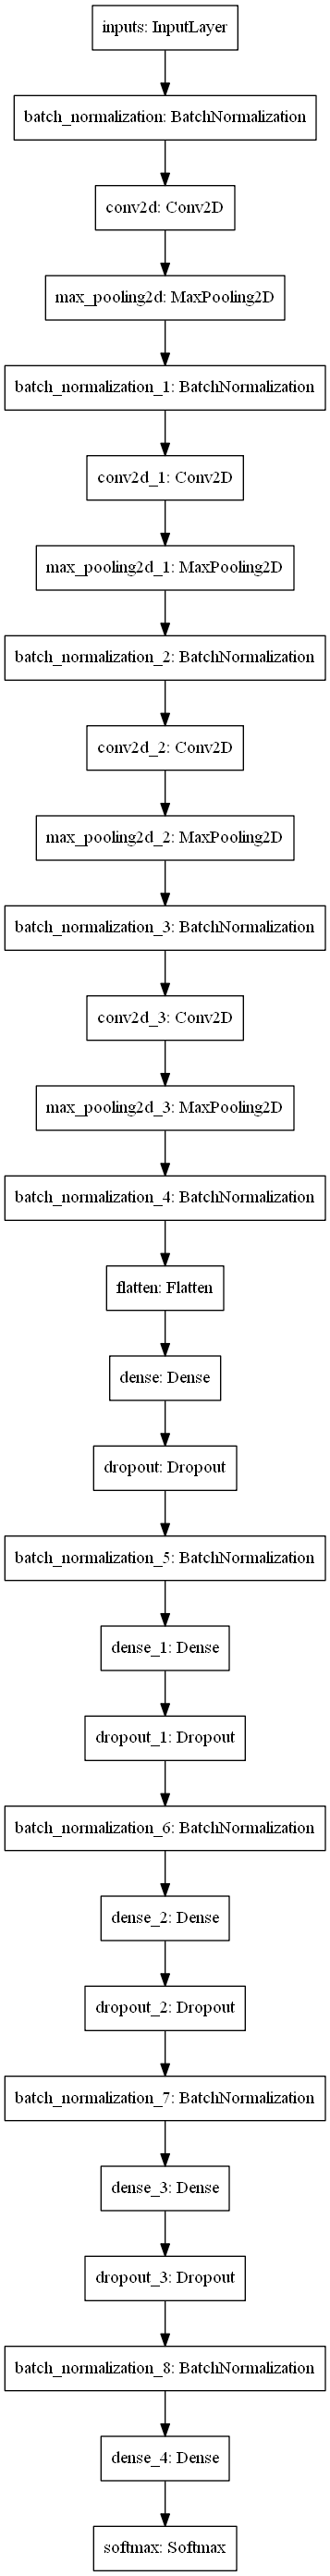

In [194]:
import os

os.environ['PATH'] = os.environ['PATH'] + ";" +  r"""C:\Users\Hamed\anaconda3\envs\image-search-engine-app\Library\bin\graphviz"""

from tensorflow.keras.utils import plot_model
# plot graph
plot_model(model.model, to_file='model.png')

## 7. Training

In [208]:
#hyperparameters
epochs = 20
learning_rate = 0.001
batch_size = 512 # 16GB RAM, you could get up to 256
drop_out_rate = 0.7 # (0.3 to 0.4 could overfit) <====================================
image_size = (32, 32)

In [221]:
image_search_ai = ImageSearchAI(drop_out_rate=drop_out_rate, 
                                image_size=image_size)
image_search_ai.compile(learning_rate=learning_rate)

(None, 32, 32, 3)
(None, 16, 16, 64)
(None, 8, 8, 128)
(None, 4, 4, 256)
(None, 2048)
(None, 128)
(None, 256)
(None, 512)
(None, 1024)


In [86]:
X_train, y_train = dataset_preprocessing("../data/raw/train", "../data/raw/labels.txt", (32, 32), "training_images_pickle")
X_test, y_test = dataset_preprocessing("../data/raw/test", "../data/raw/labels.txt", (32, 32), "testing_images_pickle")

In [87]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000,), (10000, 32, 32, 3), (10000,))

In [201]:
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import ModelCheckpoint

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='sparse_categorical_accuracy', patience=3, 
                                                           restore_best_weights=True)

check_pointer_callback = ModelCheckpoint(filepath='../models/weights.hdf5', verbose=1, save_best_only=True)

history = image_search_ai.train(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=0,
    validation_data=(X_test, y_test),
    callbacks=[TqdmCallback(verbose=1, epochs=epochs, batch_size=batch_size), early_stopping_callback, check_pointer_callback])


Epoch 00001: val_loss improved from inf to 1.28032, saving model to ../models/weights.hdf5

Epoch 00002: val_loss improved from 1.28032 to 1.14163, saving model to ../models/weights.hdf5

Epoch 00003: val_loss improved from 1.14163 to 1.08492, saving model to ../models/weights.hdf5

Epoch 00004: val_loss improved from 1.08492 to 1.01174, saving model to ../models/weights.hdf5

Epoch 00005: val_loss improved from 1.01174 to 0.92311, saving model to ../models/weights.hdf5

Epoch 00006: val_loss improved from 0.92311 to 0.86255, saving model to ../models/weights.hdf5

Epoch 00007: val_loss did not improve from 0.86255

Epoch 00008: val_loss improved from 0.86255 to 0.85689, saving model to ../models/weights.hdf5

Epoch 00009: val_loss did not improve from 0.85689

Epoch 00010: val_loss did not improve from 0.85689

Epoch 00011: val_loss did not improve from 0.85689

Epoch 00012: val_loss did not improve from 0.85689

Epoch 00013: val_loss did not improve from 0.85689

Epoch 00014: val_lo

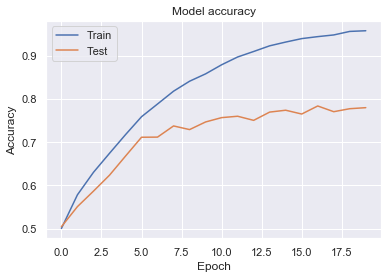

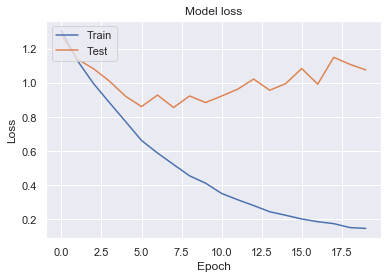

In [203]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 8. Extracting Features

<img src="../reports/conv_model_vectors.png">

In [224]:
image_search_ai.load_best_model(check_point_path="../models/weights.hdf5")

In [225]:
def extract_dense_features(data, image_search_ai):
    layer_name = 'dense_2_features'
    dense_2_features_layer_model = tf.keras.Model(inputs=image_search_ai.model.input,
                                 outputs=image_search_ai.model.get_layer(layer_name).output)
    dense_2_features_output = dense_2_features_layer_model.predict(data)
    
    layer_name = 'dense_4_features'
    dense_4_features_layer_model = tf.keras.Model(inputs=image_search_ai.model.input,
                                 outputs=image_search_ai.model.get_layer(layer_name).output)
    dense_4_features_output = dense_4_features_layer_model.predict(data)
                 
    return np.vstack(dense_2_features_output), np.vstack(dense_4_features_output)

In [228]:
def create_training_set_vectors(X_train, image_search_ai, distance='hamming'):
    
    
    dense_2_features_output, dense_4_features_output = extract_dense_features(X_train, image_search_ai)
    
    if distance == "hamming":
        dense_2_features = np.where(dense_2_features_output < 0.5, 0, 1)
        dense_4_features = np.where(dense_4_features_output < 0.5, 0, 1)
        
        training_vetors = np.hstack((dense_2_features, dense_4_features))
        
        with open("../models/hamming_training_vectors.pkl", "wb") as f:
            pickle.dump(training_vetors, f)
    
    elif distance == "cosine":
        
        training_vetors = np.hstack((dense_2_features_output, dense_4_features_output))
        
        with open("../models/cosine_training_vectors.pkl", "wb") as f:
            pickle.dump(training_vetors, f)

In [234]:
create_training_set_vectors(X_train=X_train, image_search_ai=image_search_ai, distance='hamming')

In [233]:
create_training_set_vectors(X_train=X_train, image_search_ai=image_search_ai, distance='cosine')

In [248]:
def simple_inference(training_vetors, query_image_path, image_size, image_search_ai, distance="hamming"):
    
    image =  np.expand_dims(image_loader(query_image_path, image_size), axis=0)
    
    dense_2_features_output, dense_4_features_output = extract_dense_features(image, image_search_ai)
    
    closest_ids = None
    
    if distance == "hamming":
        
        dense_2_features = np.where(dense_2_features_output < 0.5, 0, 1)
        dense_4_features = np.where(dense_4_features_output < 0.5, 0, 1)
        
        query_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = hamming_distance(training_vetors, query_image_vector)
        
    elif distance == "cosine":
        
        query_image_vector = np.hstack((dense_2_features_output, dense_4_features_output))
        
        closest_ids = cosine_distance(training_vetors, query_image_vector)
        
    return closest_ids   

In [235]:
with open("../models/cosine_training_vectors.pkl", "rb") as f:
    cosine_training_vectors = pickle.load(f)

with open("../models/hamming_training_vectors.pkl", "rb") as f:
    hamming_training_vectors = pickle.load(f)

In [256]:
cosine_similar_ids = simple_inference(training_vetors=cosine_training_vectors, query_image_path="../data/raw/test/1005_automobile.png", image_size=(32, 32), image_search_ai=image_search_ai, distance="cosine")

In [271]:
with open('../data/preprocessed/training_images_path_pickle.pkl', 'rb') as f:
    train_image_paths = pickle.load(f)
        
def show_image_results(result_ids):
    fig = plt.figure(figsize=(16, 16))
    colums = 10
    rows = 5
    for i in range(1, colums*rows+1):
        try:
            image = image_loader(train_image_paths[result_ids[i]], image_size)
            fig.add_subplot(rows, colums, i)
            plt.imshow(image)
        except:
            pass

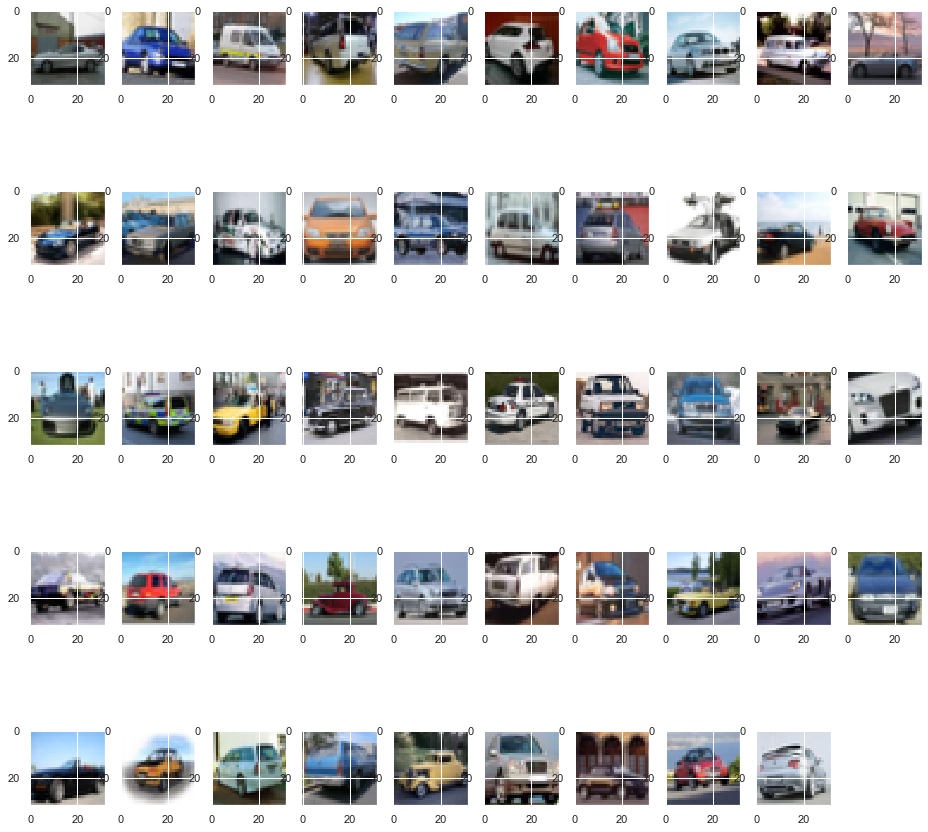

In [272]:
show_image_results(cosine_similar_ids)
plt.show()

In [255]:
hamming_similar_ids = simple_inference(training_vetors=hamming_training_vectors, query_image_path="../data/raw/test/1005_automobile.png", image_size=(32, 32), image_search_ai=image_search_ai, distance="hamming")

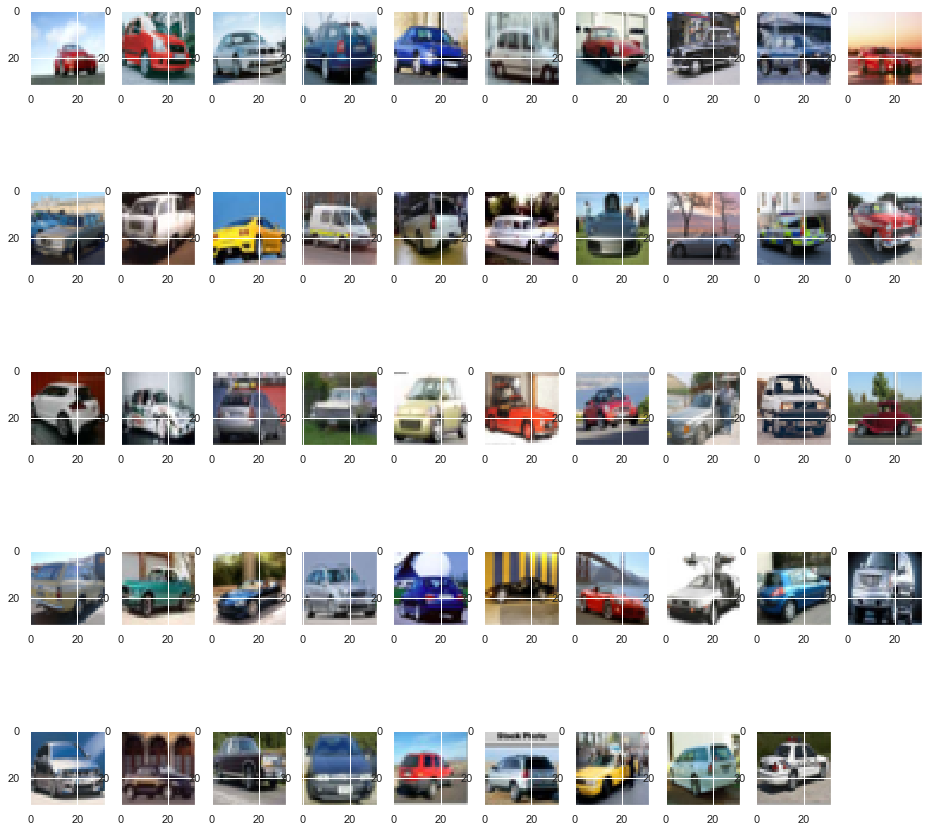

In [273]:
show_image_results(hamming_similar_ids)
plt.show()